# Box Plots

Experimenting with Box Plots for analysis

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jupyter_black

jupyter_black.load(
    lab=False,
    line_length=79,
    verbosity="DEBUG",
)

DEBUG:jupyter_black:config: {'line_length': 79}


<IPython.core.display.Javascript object>

In [3]:
# Import packages
import os
import warnings

# import geopandas
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import linear_model, preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, KFold, train_test_split

import statsmodels.api as sm
import statsmodels.formula.api as smf
from tabulate import tabulate

In [4]:
matplotlib.rcParams.update({"font.size": 22})

In [5]:
import warnings

warnings.filterwarnings("ignore")

In [6]:
FIGURES_DIR = os.path.join("..", "figures")

In [7]:
# Prep demographic data
CSV_DIR = os.path.join("..", "csv_data")


credits_race_income_demographics_df = pd.read_csv(
    os.path.join(
        CSV_DIR,
        "tax_credits_with_agi_demographic_zipcode_decade_updated_interpolated.csv",
    )
)

In [8]:
credits_race_filtered_df = credits_race_income_demographics_df[
    credits_race_income_demographics_df["percent_white_alone"].notna()
]

credits_race_filtered_df["value_returns"] = credits_race_filtered_df[
    "value_returns"
].fillna(0, inplace=False)

credits_race_filtered_df["percent_returns"] = credits_race_filtered_df[
    "percent_returns"
].fillna(0, inplace=False)

credits_race_filtered_df = credits_race_filtered_df[
    credits_race_filtered_df["percent_returns"] <= 100
]

credits_race_filtered_df = credits_race_filtered_df[
    credits_race_filtered_df["Total Returns"] >= 1
]

credits_race_filtered_df = credits_race_filtered_df[
    (credits_race_filtered_df["Number of returns"] >= 1)
    | (credits_race_filtered_df["Number of returns"] == 0)
]

credits_race_filtered_df = credits_race_filtered_df[
    (credits_race_filtered_df["Amount of returns"] >= 1)
    | (credits_race_filtered_df["Amount of returns"] == 0)
]

In [9]:
credits_race_filtered_df

,STATEFIPS,STATE,zipcode,agi_stub,Total Returns,Number of returns,Amount of returns,Number of real estate taxes,year,value_returns,percent_returns,state_participation,relative_to_state_participation,percent_homeowners,median_income,percent_white_alone
1,1,AL,35004,2,1271.0,82.0,45.0,450.0,2009,548.780488,6.451613,5.108432,1.262934,35.405193,62281.0,86.515269
2,1,AL,35004,3,911.0,73.0,58.0,524.0,2009,794.520548,8.013172,5.108432,1.568617,57.519210,62281.0,86.515269
3,1,AL,35004,4,552.0,63.0,36.0,398.0,2009,571.428571,11.413043,5.108432,2.234158,72.101449,62281.0,86.515269
4,1,AL,35004,5,371.0,41.0,31.0,298.0,2009,756.097561,11.051213,5.108432,2.163328,80.323450,62281.0,86.515269
7,1,AL,35004,2,1248.0,69.0,39.0,406.0,2010,565.217391,5.528846,5.490163,1.007046,32.532051,62281.0,85.806080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1742200,51,VA,22729,2,20.0,0.0,0.0,0.0,2020,0.000000,0.000000,1.339147,0.000000,0.000000,76667.0,51.174497
1742201,51,VA,22729,3,30.0,0.0,0.0,0.0,2020,0.000000,0.000000,1.339147,0.000000,0.000000,76667.0,51.174497
1742202,53,WA,98833,1,40.0,0.0,0.0,0.0,2020,0.000000,0.000000,0.964554,0.000000,0.000000,69615.0,89.166667
1742203,53,WA,98833,3,30.0,0.0,0.0,0.0,2020,0.000000,0.000000,0.964554,0.000000,0.000000,69615.0,89.166667


In [10]:
credits_participated_df = credits_race_filtered_df[
    credits_race_filtered_df["Number of returns"] > 0
]

In [11]:
credits_race_filtered_df.columns

Index(['STATEFIPS', 'STATE', 'zipcode', 'agi_stub', 'Total Returns',
       'Number of returns', 'Amount of returns', 'Number of real estate taxes',
       'year', 'value_returns', 'percent_returns', 'state_participation',
       'relative_to_state_participation', 'percent_homeowners',
       'median_income', 'percent_white_alone'],
      dtype='object')

In [12]:
mean_color = "#e66101"
median_color = "#5e3c99"

medianprops = dict(linestyle="solid", linewidth=2.5, color=median_color)

meanlineprops = dict(linestyle="dashed", linewidth=2.5, color=mean_color)

## Participation

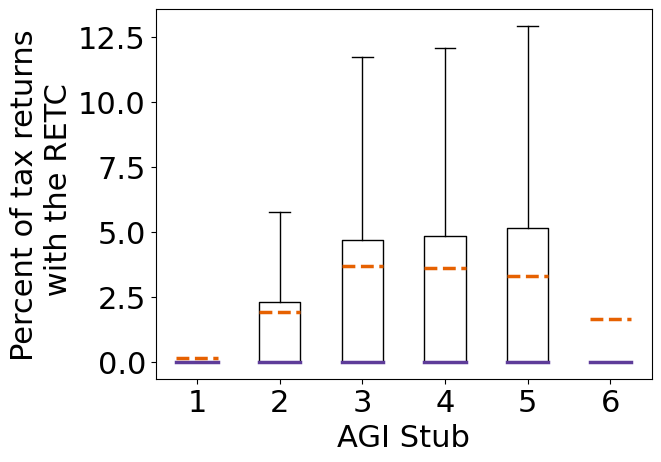

In [13]:
agi_data = []
means_and_medians = []
header = ["AGI stub", "Mean", "Median"]
means_and_medians.append(header)

for agi_stub in sorted(credits_race_filtered_df.agi_stub.unique()):
    # for agi_stub in sorted(credits_participated_df.agi_stub.unique()):
    agi_subset = credits_race_filtered_df[
        credits_race_filtered_df["agi_stub"] == agi_stub
    ]
    agi_data.append(agi_subset["percent_returns"])
    mean = np.mean(agi_subset["percent_returns"])
    median = np.median(agi_subset["percent_returns"])
    agi_subset_data = [agi_stub, mean, median]
    means_and_medians.append(agi_subset_data)

fig, ax = plt.subplots()
ax.boxplot(
    agi_data,
    showfliers=False,
    showmeans=True,
    meanline=True,
    meanprops=meanlineprops,
    medianprops=medianprops,
)

plt.ylabel("Percent of tax returns\n with the RETC")
plt.xlabel("AGI Stub")
plt.savefig(
    os.path.join(FIGURES_DIR, "agi_participation_boxplot.pdf"),
    format="pdf",
    bbox_inches="tight",
)
plt.show()

In [14]:
table2 = tabulate(means_and_medians, headers="firstrow")

print(table2)

  AGI stub      Mean    Median
----------  --------  --------
         1  0.168313         0
         2  1.91795          0
         3  3.7037           0
         4  3.60271          0
         5  3.30345          0
         6  1.63444          0


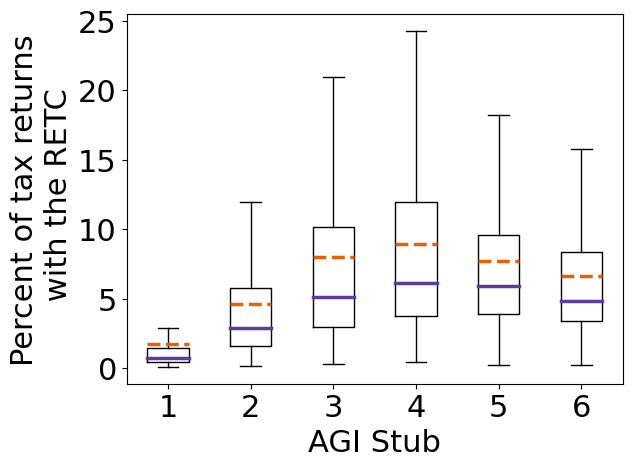

In [15]:
agi_data = []
means_and_medians = []
header = ["AGI stub", "Mean", "Median"]
means_and_medians.append(header)

for agi_stub in sorted(credits_participated_df.agi_stub.unique()):
    agi_subset = credits_participated_df[
        credits_participated_df["agi_stub"] == agi_stub
    ]
    agi_data.append(agi_subset["percent_returns"])
    mean = np.mean(agi_subset["percent_returns"])
    median = np.median(agi_subset["percent_returns"])
    agi_subset_data = [agi_stub, mean, median]
    means_and_medians.append(agi_subset_data)

fig, ax = plt.subplots()
ax.boxplot(
    agi_data,
    showfliers=False,
    showmeans=True,
    meanline=True,
    meanprops=meanlineprops,
    medianprops=medianprops,
)
plt.ylabel("Percent of tax returns\n with the RETC")
plt.xlabel("AGI Stub")
plt.savefig(
    os.path.join(
        FIGURES_DIR, "agi_participation_boxplot_only_participated.pdf"
    ),
    format="pdf",
    bbox_inches="tight",
)
plt.show()

In [16]:
table2 = tabulate(means_and_medians, headers="firstrow")

print(table2)

  AGI stub     Mean    Median
----------  -------  --------
         1  1.72262  0.725953
         2  4.59501  2.91048
         3  7.97125  5.12821
         4  8.92665  6.13915
         5  7.71833  5.88235
         6  6.59962  4.83302


## Average value

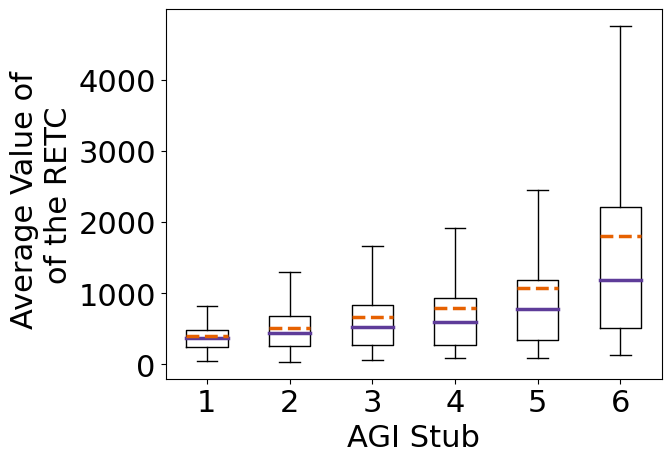

In [17]:
agi_data = []
means_and_medians = []
header = ["AGI stub", "Mean", "Median"]
means_and_medians.append(header)

# for agi_stub in sorted(credits_race_filtered_df.agi_stub.unique()):
for agi_stub in sorted(credits_participated_df.agi_stub.unique()):
    agi_subset = credits_participated_df[
        credits_participated_df["agi_stub"] == agi_stub
    ]
    agi_data.append(agi_subset["value_returns"])
    mean = np.mean(agi_subset["value_returns"])
    median = np.median(agi_subset["value_returns"])
    agi_subset_data = [agi_stub, mean, median]
    means_and_medians.append(agi_subset_data)

fig, ax = plt.subplots()
ax.boxplot(
    agi_data,
    showfliers=False,
    showmeans=True,
    meanline=True,
    meanprops=meanlineprops,
    medianprops=medianprops,
)
plt.ylabel("Average Value of \nof the RETC")
plt.xlabel("AGI Stub")
plt.savefig(
    os.path.join(FIGURES_DIR, "agi_average_value_boxplot.pdf"),
    format="pdf",
    bbox_inches="tight",
)
plt.show()

In [18]:
table2 = tabulate(means_and_medians, headers="firstrow")

print(table2)

  AGI stub      Mean    Median
----------  --------  --------
         1   397.882   366.667
         2   515.521   440
         3   662.267   525
         4   788.089   600
         5  1070.32    775
         6  1806.77   1181.03


## Segmenting urban vs rural

In [23]:
zipcode_urban_vs_rural_2010_df = pd.read_csv(
    "~/Downloads/DECENNIALSF12010.H2_2023-11-10T103031/DECENNIALSF12010.H2-Data.csv"
)
zipcode_urban_vs_rural_2010_df["zipcode"] = (
    zipcode_urban_vs_rural_2010_df["Geographic Area Name"].astype(str).str[-5:]
)
zipcode_urban_vs_rural_2010_df["urban_category"] = 0
zipcode_urban_vs_rural_2010_df.loc[
    zipcode_urban_vs_rural_2010_df["Total Urban"]
    >= zipcode_urban_vs_rural_2010_df["Total Rural"],
    "urban_category",
] = 1
zipcode_urban_vs_rural_2010_df = zipcode_urban_vs_rural_2010_df[
    ["zipcode", "urban_category"]
]
zipcode_urban_vs_rural_2010_df

,zipcode,urban_category
0,00601,1
1,00602,1
2,00603,1
3,00606,0
4,00610,1
...,...,...
33115,99923,0
33116,99925,0
33117,99926,0
33118,99927,0


In [24]:
zipcode_urban_vs_rural_2020_df = pd.read_csv(
    "~/Downloads/DECENNIALDHC2020.H2_2023-11-08T145318/DECENNIALDHC2020.H2-Data.csv"
)
zipcode_urban_vs_rural_2020_df["zipcode"] = (
    zipcode_urban_vs_rural_2020_df["Geographic Area Name"].astype(str).str[-5:]
)
zipcode_urban_vs_rural_2020_df["urban_category"] = 0
zipcode_urban_vs_rural_2020_df.loc[
    zipcode_urban_vs_rural_2020_df["  Total: Urban"]
    >= zipcode_urban_vs_rural_2020_df["  Total: Rural"],
    "urban_category",
] = 1
zipcode_urban_vs_rural_2020_df = zipcode_urban_vs_rural_2020_df[
    ["zipcode", "urban_category"]
]
zipcode_urban_vs_rural_2020_df

,zipcode,urban_category
0,00601,0
1,00602,1
2,00603,1
3,00606,0
4,00610,1
...,...,...
33769,99923,0
33770,99925,0
33771,99926,0
33772,99927,0


In [25]:
credits_race_filtered_df["zipcode"] = (
    credits_race_filtered_df["zipcode"].astype(str).str.zfill(5)
)

credits_race_filtered_2010_df = credits_race_filtered_df[
    credits_race_filtered_df["year"] < 2015
]
credits_race_filtered_2020_df = credits_race_filtered_df[
    credits_race_filtered_df["year"] >= 2015
]


credits_urban_rural_2010_df = pd.merge(
    credits_race_filtered_2010_df,
    zipcode_urban_vs_rural_2010_df,
    on="zipcode",
    how="left",
)

credits_urban_rural_2020_df = pd.merge(
    credits_race_filtered_2020_df,
    zipcode_urban_vs_rural_2020_df,
    on="zipcode",
    how="left",
)

credits_urban_rural_df = pd.concat(
    [credits_urban_rural_2010_df, credits_urban_rural_2020_df],
    ignore_index=True,
)
credits_urban_rural_df

,STATEFIPS,STATE,zipcode,agi_stub,Total Returns,Number of returns,Amount of returns,Number of real estate taxes,year,value_returns,percent_returns,state_participation,relative_to_state_participation,percent_homeowners,median_income,percent_white_alone,urban_category
0,1,AL,35004,2,1271.0,82.0,45.0,450.0,2009,548.780488,6.451613,5.108432,1.262934,35.405193,62281.0,86.515269,1
1,1,AL,35004,3,911.0,73.0,58.0,524.0,2009,794.520548,8.013172,5.108432,1.568617,57.519210,62281.0,86.515269,1
2,1,AL,35004,4,552.0,63.0,36.0,398.0,2009,571.428571,11.413043,5.108432,2.234158,72.101449,62281.0,86.515269,1
3,1,AL,35004,5,371.0,41.0,31.0,298.0,2009,756.097561,11.051213,5.108432,2.163328,80.323450,62281.0,86.515269,1
4,1,AL,35004,2,1248.0,69.0,39.0,406.0,2010,565.217391,5.528846,5.490163,1.007046,32.532051,62281.0,85.806080,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1567669,51,VA,22729,2,20.0,0.0,0.0,0.0,2020,0.000000,0.000000,1.339147,0.000000,0.000000,76667.0,51.174497,0
1567670,51,VA,22729,3,30.0,0.0,0.0,0.0,2020,0.000000,0.000000,1.339147,0.000000,0.000000,76667.0,51.174497,0
1567671,53,WA,98833,1,40.0,0.0,0.0,0.0,2020,0.000000,0.000000,0.964554,0.000000,0.000000,69615.0,89.166667,0
1567672,53,WA,98833,3,30.0,0.0,0.0,0.0,2020,0.000000,0.000000,0.964554,0.000000,0.000000,69615.0,89.166667,0


In [26]:
# credits_race_filtered_urban_df = pd.merge(credits_race_filtered_df, zipcode_urban_vs_rural_df, on="zipcode", how="left")
# credits_participated_urban_df = pd.merge(credits_participated_df, zipcode_urban_vs_rural_df, on="zipcode", how="left")

In [29]:
credits_urban = credits_urban_rural_df[
    credits_urban_rural_df["urban_category"] == 1
]
credits_rural = credits_urban_rural_df[
    credits_urban_rural_df["urban_category"] == 0
]

In [30]:
credits_urban_participated = credits_urban[
    credits_urban["Number of returns"] >= 1
]

credits_rural_participated = credits_rural[
    credits_rural["Number of returns"] >= 1
]

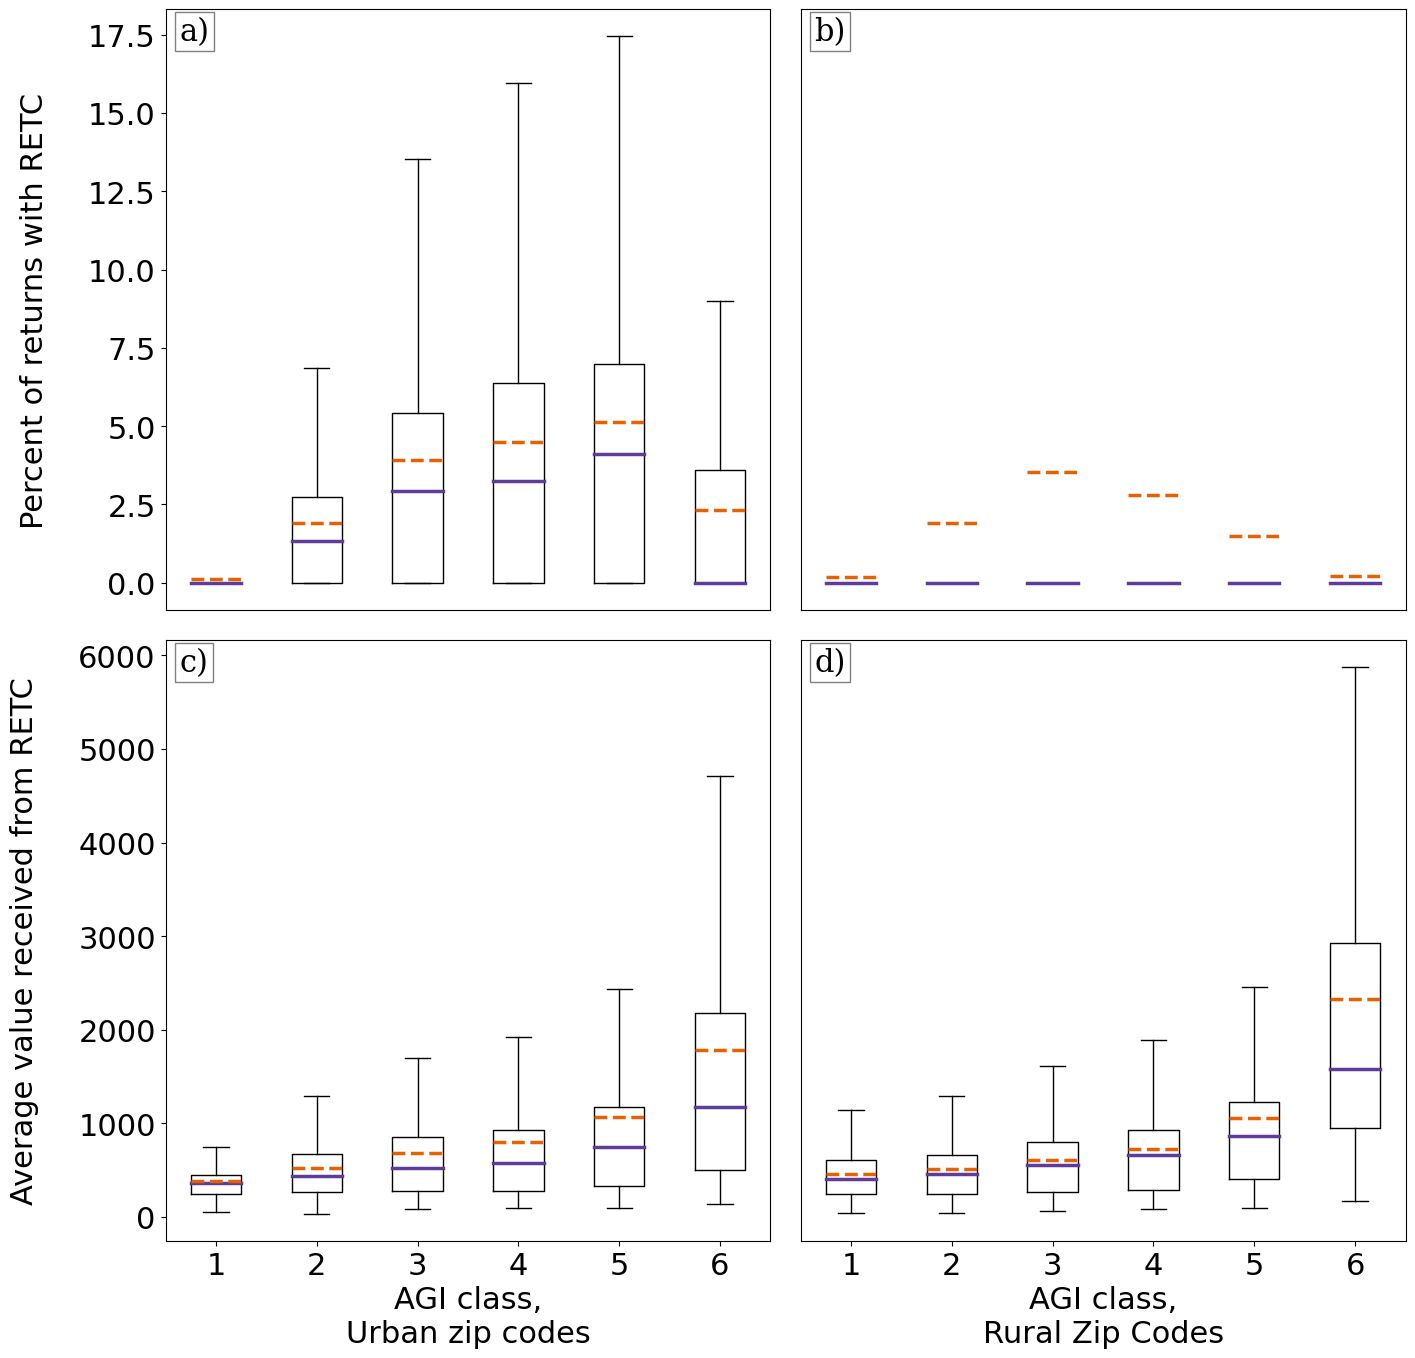

In [32]:
import matplotlib.transforms as mtransforms

fig, axes = plt.subplots(
    nrows=2,
    ncols=2,
    figsize=(16, 16),
    gridspec_kw={"wspace": 0.05, "hspace": 0.05},
)


subplot_labels = ["a)", "b)", "c)", "d)"]
trans = mtransforms.ScaledTranslation(10 / 72, -5 / 72, fig.dpi_scale_trans)
#######################################################

agi_data = []
means_and_medians = []
header = ["AGI stub", "Mean", "Median"]
means_and_medians.append(header)

for agi_stub in sorted(credits_urban.agi_stub.unique()):
    agi_subset = credits_urban[credits_urban["agi_stub"] == agi_stub]
    agi_data.append(agi_subset["percent_returns"])

axes[0][0].boxplot(
    agi_data,
    showfliers=False,
    showmeans=True,
    meanline=True,
    meanprops=meanlineprops,
    medianprops=medianprops,
)
axes[0][0].set_ylabel("Percent of returns with RETC\n")
# axes[0][0].set_xlabel("AGI class,\nUrban Zip Codes")
axes[0][0].text(
    0.0,
    1.0,
    subplot_labels[0],
    transform=axes[0][0].transAxes + trans,
    fontsize="medium",
    verticalalignment="top",
    fontfamily="serif",
    bbox=dict(facecolor="none", edgecolor="gray", pad=3.0),
)

#######################################################

agi_data = []
means_and_medians = []
header = ["AGI stub", "Mean", "Median"]
means_and_medians.append(header)

# for agi_stub in sorted(credits_race_filtered_df.agi_stub.unique()):
for agi_stub in sorted(credits_rural.agi_stub.unique()):
    agi_subset = credits_rural[credits_rural["agi_stub"] == agi_stub]
    agi_data.append(agi_subset["percent_returns"])

axes[0][1].boxplot(
    agi_data,
    showfliers=False,
    showmeans=True,
    meanline=True,
    meanprops=meanlineprops,
    medianprops=medianprops,
)

# axes[0][1].set_xlabel("AGI class,\nRural Zip Codes")
axes[0][1].text(
    0.0,
    1.0,
    subplot_labels[1],
    transform=axes[0][1].transAxes + trans,
    fontsize="medium",
    verticalalignment="top",
    fontfamily="serif",
    bbox=dict(facecolor="none", edgecolor="gray", pad=3.0),
)

#######################################################


agi_data = []
means_and_medians = []
header = ["AGI stub", "Mean", "Median"]
means_and_medians.append(header)

for agi_stub in sorted(credits_urban_participated.agi_stub.unique()):
    agi_subset = credits_urban_participated[
        credits_urban_participated["agi_stub"] == agi_stub
    ]
    agi_data.append(agi_subset["value_returns"])

axes[1][0].boxplot(
    agi_data,
    showfliers=False,
    showmeans=True,
    meanline=True,
    meanprops=meanlineprops,
    medianprops=medianprops,
)
axes[1][0].set_ylabel("Average value received from RETC\n")
axes[1][0].set_xlabel("AGI class,\nUrban zip codes")
axes[1][0].text(
    0.0,
    1.0,
    subplot_labels[2],
    transform=axes[1][0].transAxes + trans,
    fontsize="medium",
    verticalalignment="top",
    fontfamily="serif",
    bbox=dict(facecolor="none", edgecolor="gray", pad=3.0),
)

#######################################################


agi_data = []
means_and_medians = []
header = ["AGI stub", "Mean", "Median"]
means_and_medians.append(header)

for agi_stub in sorted(credits_rural_participated.agi_stub.unique()):
    agi_subset = credits_rural_participated[
        credits_rural_participated["agi_stub"] == agi_stub
    ]
    agi_data.append(agi_subset["value_returns"])


axes[1][1].boxplot(
    agi_data,
    showfliers=False,
    showmeans=True,
    meanline=True,
    meanprops=meanlineprops,
    medianprops=medianprops,
)

axes[1][1].set_xlabel("AGI class,\nRural Zip Codes")
axes[1][1].text(
    0.0,
    1.0,
    subplot_labels[3],
    transform=axes[1][1].transAxes + trans,
    fontsize="medium",
    verticalalignment="top",
    fontfamily="serif",
    bbox=dict(facecolor="none", edgecolor="gray", pad=3.0),
)

################################################

# X-axis
for tick in axes[0][0].xaxis.get_major_ticks():
    tick.tick1line.set_visible(False)
    tick.tick2line.set_visible(False)
    tick.label1.set_visible(False)
    tick.label2.set_visible(False)

for tick in axes[0][1].xaxis.get_major_ticks():
    tick.tick1line.set_visible(False)
    tick.tick2line.set_visible(False)
    tick.label1.set_visible(False)
    tick.label2.set_visible(False)

# Y axis

axes[0][1].sharey(axes[0][0])
axes[1][1].sharey(axes[1][0])

for tick in axes[0][1].yaxis.get_major_ticks():
    tick.tick1line.set_visible(False)
    tick.tick2line.set_visible(False)
    tick.label1.set_visible(False)
    tick.label2.set_visible(False)

for tick in axes[1][1].yaxis.get_major_ticks():
    tick.tick1line.set_visible(False)
    tick.tick2line.set_visible(False)
    tick.label1.set_visible(False)
    tick.label2.set_visible(False)

plt.savefig(
    os.path.join(
        FIGURES_DIR, "agi_participation_value_urban_boxplots_subplots.pdf"
    ),
    format="pdf",
    bbox_inches="tight",
)
plt.show()

In [33]:
# Participation, Urban
total_outliers = 0
for agi_stub in sorted(credits_urban.agi_stub.unique()):
    agi_subset = credits_urban[credits_urban["agi_stub"] == agi_stub]
    mean = agi_subset["percent_returns"].mean()
    median = agi_subset["percent_returns"].median()
    print(f"AGI {agi_stub}: {round(mean, 2)}\% & {round(median,2)}\%")

    Q1 = agi_subset["percent_returns"].quantile(0.25)
    Q3 = agi_subset["percent_returns"].quantile(0.75)
    IQR = Q3 - Q1

    num_outliers = len(
        agi_subset[
            (agi_subset["percent_returns"] < (Q1 - 1.5 * IQR))
            | (agi_subset["percent_returns"] > (Q3 + 1.5 * IQR))
        ]
    )
    #     print(f"AGI class {agi_stub} has {num_outliers} outliers")
    total_outliers = total_outliers + num_outliers

percent_outliers = float(total_outliers) / float(len(credits_urban)) * 100
print(percent_outliers)

AGI 1: 0.13\% & 0.0\%
AGI 2: 1.91\% & 1.33\%
AGI 3: 3.92\% & 2.94\%
AGI 4: 4.49\% & 3.26\%
AGI 5: 5.14\% & 4.12\%
AGI 6: 2.31\% & 0.0\%
6.725066349215608


In [34]:
# Participation, rural
total_outliers = 0
for agi_stub in sorted(credits_rural.agi_stub.unique()):
    agi_subset = credits_rural[credits_rural["agi_stub"] == agi_stub]
    mean = agi_subset["percent_returns"].mean()
    median = agi_subset["percent_returns"].median()
    print(f"AGI {agi_stub}: {round(mean, 4)}\% & {round(median,2)}\%")

    Q1 = agi_subset["percent_returns"].quantile(0.25)
    Q3 = agi_subset["percent_returns"].quantile(0.75)
    IQR = Q3 - Q1

    num_outliers = len(
        agi_subset[
            (agi_subset["percent_returns"] < (Q1 - 1.5 * IQR))
            | (agi_subset["percent_returns"] > (Q3 + 1.5 * IQR))
        ]
    )
    #     print(f"AGI class {agi_stub} has {num_outliers} outliers")
    total_outliers = total_outliers + num_outliers

percent_outliers = float(total_outliers) / float(len(credits_rural)) * 100
print(percent_outliers)

AGI 1: 0.1944\% & 0.0\%
AGI 2: 1.9243\% & 0.0\%
AGI 3: 3.5248\% & 0.0\%
AGI 4: 2.8049\% & 0.0\%
AGI 5: 1.4886\% & 0.0\%
AGI 6: 0.2306\% & 0.0\%
15.322033314808714


In [35]:
# Value, only those that participated
total_outliers = 0
for agi_stub in sorted(credits_urban_participated.agi_stub.unique()):
    agi_subset = credits_urban_participated[
        credits_urban_participated["agi_stub"] == agi_stub
    ]
    mean = agi_subset["value_returns"].mean()
    median = agi_subset["value_returns"].median()
    print(f"AGI 1: \${round(mean, 2)} & \${round(median,2)}")

    Q1 = agi_subset["value_returns"].quantile(0.25)
    Q3 = agi_subset["value_returns"].quantile(0.75)
    IQR = Q3 - Q1

    num_outliers = len(
        agi_subset[
            (agi_subset["value_returns"] < (Q1 - 1.5 * IQR))
            | (agi_subset["value_returns"] > (Q3 + 1.5 * IQR))
        ]
    )
    # print(f"AGI class {agi_stub} has {num_outliers} outliers")
    total_outliers = total_outliers + num_outliers

percent_outliers = (
    float(total_outliers) / float(len(credits_urban_participated)) * 100
)
print(percent_outliers)

AGI 1: \$379.48 & \$360.0
AGI 1: \$518.86 & \$433.33
AGI 1: \$683.71 & \$520.0
AGI 1: \$805.43 & \$575.0
AGI 1: \$1072.91 & \$750.0
AGI 1: \$1788.35 & \$1169.81
7.01611025748475


In [36]:
# Value, only those that participated
total_outliers = 0
for agi_stub in sorted(credits_rural_participated.agi_stub.unique()):
    agi_subset = credits_rural_participated[
        credits_rural_participated["agi_stub"] == agi_stub
    ]
    mean = agi_subset["value_returns"].mean()
    median = agi_subset["value_returns"].median()
    print(f"AGI 1: \${round(mean, 2)} & \${round(median,2)}")

    Q1 = agi_subset["value_returns"].quantile(0.25)
    Q3 = agi_subset["value_returns"].quantile(0.75)
    IQR = Q3 - Q1

    num_outliers = len(
        agi_subset[
            (agi_subset["value_returns"] < (Q1 - 1.5 * IQR))
            | (agi_subset["value_returns"] > (Q3 + 1.5 * IQR))
        ]
    )
    # print(f"AGI class {agi_stub} has {num_outliers} outliers")
    total_outliers = total_outliers + num_outliers

percent_outliers = (
    float(total_outliers) / float(len(credits_rural_participated)) * 100
)
print(percent_outliers)

AGI 1: \$457.1 & \$409.09
AGI 1: \$507.37 & \$460.0
AGI 1: \$605.2 & \$550.0
AGI 1: \$728.12 & \$666.67
AGI 1: \$1056.38 & \$869.57
AGI 1: \$2327.61 & \$1584.16
3.46736853930781
